Takes in .AWD, sleep log if it exists, calendar, and spits out some pretty pictures

In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, '/data/MoodGroup/actigraphy/gavi/actigraPy') 

import actigraPy.actigraPy as act
import importlib
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

/data/MoodGroup/actigraphy/gavi/actigraPy/actigraPy/actigraPy.py:23: MatplotlibDeprecationWarning: 
The matplotlib.backends.tkagg module was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import matplotlib.backends.tkagg as tkagg


If you want to run the test data, run this cell instead of the one below

In [2]:
# data and log directories
sub = 'TEST' #subject NUMBER as STRING
sub_long = 'TEST'

out_dir = '/data/MoodGroup/actigraphy/gavi/actigraPy/data/output' #output directory
data_dir = '/data/MoodGroup/actigraphy/gavi/actigraPy/data'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)


## Subject and directory info

In [3]:
fn = {}
#.AWD
awd_fn = os.path.join(data_dir, '%s.AWD'%sub_long)
#sleeplog
fn['cal']= os.path.join(data_dir, '%s_calendar_log.xls'%sub_long)
#calendar
fn['log'] = os.path.join(data_dir, '%s_sleeplog.xls'%sub_long)
logs = []

if os.path.isfile(awd_fn):
    for name in fn.keys():
        if os.path.isfile(fn[name]):
            print("%s has %s file at %s"%(sub,name,fn[name]))
            logs.append(fn[name])
        else:
            print("no " + name)
            fn[name] = ''
else:
    print("DO NOT CONTINUE!! THERE IS NO AWD FILE")

TEST has cal file at /data/MoodGroup/actigraphy/gavi/actigraPy/data/TEST_calendar_log.xls
TEST has log file at /data/MoodGroup/actigraphy/gavi/actigraPy/data/TEST_sleeplog.xls


### Make Mtimes file

Figure out where to clip awd file

In [4]:
awd_dat = act.read_AWD(awd_fn)


In [5]:
#read AWD file
awd_dat = act.read_AWD(awd_fn)
idx={'start':[0],'end':[len(awd_dat['dt_list'])-1]}
#get the start and stops from each log if they exist
for log in logs:
    print(log)
    _, kw_dat = act.read_log(log,awd_dat)
    
    if 'watch_on' in kw_dat.keys():
        on_date = kw_dat['watch_on'].iloc[0]['OnDate']
        on_time = kw_dat['watch_on'].iloc[0]['OnTime']
        on = datetime(on_date.year,on_date.month,on_date.day,on_time.hour,on_time.minute)
        #check if that time is in dt_list:
        if awd_dat['dt_list'].count(on) > 0:
            on_idx=awd_dat['dt_list'].index(on)
            idx['start'].append(on_idx)

    if 'watch_off' in kw_dat.keys():
        off_date = kw_dat['watch_off'].iloc[0]['OffDate']
        off_time = kw_dat['watch_off'].iloc[0]['OffTime']
        off = datetime(off_date.year,off_date.month,off_date.day,off_time.hour,off_time.minute)
        if awd_dat['dt_list'].count(off) > 0:
            off_idx=awd_dat['dt_list'].index(off)
            idx['end'].append(off_idx)
 
idx

/data/MoodGroup/actigraphy/gavi/actigraPy/data/TEST_calendar_log.xls
     OffDate   OffTime     OnDate    OnTime                Comment
0        NaT       NaN 2016-02-08  10:00:00                  start
1 2016-02-07  13:00:00 2016-02-07  14:30:00  Fake, for bug testing
2 2016-02-08  13:00:00 2016-02-08  14:30:00                     3T
3 2016-02-08  21:30:00 2016-02-09  07:00:00            Sleep study
4 2016-02-09  14:00:00 2016-02-09  16:00:00                     7T
5 2016-02-10  10:00:00 2016-02-10  12:00:00                    NaN
6 2016-02-10  21:30:00 2016-02-11  07:00:00            Sleep study
7 2016-02-11  09:00:00 2016-02-11  09:40:00               Infusion
8 2016-02-11  15:00:00 2016-02-11  17:00:00                    MEG
/data/MoodGroup/actigraphy/gavi/actigraPy/data/TEST_sleeplog.xls
     OffDate   OffTime     OnDate    OnTime Comment
0        NaT       NaN 2016-02-08  15:40:00   start
1 2016-02-09  00:42:00 2016-02-09  01:20:00  shower
2 2016-02-09  13:45:00 2016-02-09  16:35

{'start': [0, 144], 'end': [4741]}

In [6]:
start = max(idx['start'])
end = min(idx['end'])
print('start = %d, end = %d'%(start,end))

start = 144, end = 4741


## <font color='red'>Make sure the starts and ends make sense before clipping the data</font>


In [7]:
#modify these according to output from above!!
lim = [awd_dat['DateTime'][start],awd_dat['DateTime'][end]]
clip_dat = act.clip_dat(lim,awd_dat)

## Now just run these cells in order to extract comments and write Mtimes

In [8]:
importlib.reload(act)
#Make master mk_idx
mk_idx=act.get_markers(awd_dat,fn['log'])

     OffDate   OffTime     OnDate    OnTime Comment
0        NaT       NaN 2016-02-08  15:40:00   start
1 2016-02-09  00:42:00 2016-02-09  01:20:00  shower
2 2016-02-09  13:45:00 2016-02-09  16:35:00  7T MRI
3 2016-02-09  23:25:00 2016-02-10  00:05:00  shower
4 2016-02-10  19:15:00 2016-02-10  20:07:00  shower
5 2016-02-11  15:00:00 2016-02-11  17:00:00     MEG


In [9]:
importlib.reload(act)
#Make master mk_idx
mk_idx=act.get_markers(awd_dat)

In [10]:
importlib.reload(act)
#Read logs
for name in fn.keys():
    if os.path.isfile(fn[name]):
        log_dat,kw_dat= act.read_log(fn[name],awd_dat)
        mk_idx[name]=log_dat['idx']
        


     OffDate   OffTime     OnDate    OnTime                Comment
0        NaT       NaN 2016-02-08  10:00:00                  start
1 2016-02-07  13:00:00 2016-02-07  14:30:00  Fake, for bug testing
2 2016-02-08  13:00:00 2016-02-08  14:30:00                     3T
3 2016-02-08  21:30:00 2016-02-09  07:00:00            Sleep study
4 2016-02-09  14:00:00 2016-02-09  16:00:00                     7T
5 2016-02-10  10:00:00 2016-02-10  12:00:00                    NaN
6 2016-02-10  21:30:00 2016-02-11  07:00:00            Sleep study
7 2016-02-11  09:00:00 2016-02-11  09:40:00               Infusion
8 2016-02-11  15:00:00 2016-02-11  17:00:00                    MEG
     OffDate   OffTime     OnDate    OnTime Comment
0        NaT       NaN 2016-02-08  15:40:00   start
1 2016-02-09  00:42:00 2016-02-09  01:20:00  shower
2 2016-02-09  13:45:00 2016-02-09  16:35:00  7T MRI
3 2016-02-09  23:25:00 2016-02-10  00:05:00  shower
4 2016-02-10  19:15:00 2016-02-10  20:07:00  shower
5 2016-02-11  15:0

In [11]:
importlib.reload(act)
act.write_Mtimes(awd_dat,mk_idx,os.path.join(out_dir,sub_long))

OnDate    OnTime    OffDate   OffTime marker      Comment
0   08-Feb-16  01:16 PM  08-Feb-16  02:30 PM    cal           3T
1   08-Feb-16  01:16 PM  08-Feb-16  02:35 PM      z             
2   08-Feb-16  02:43 PM  08-Feb-16  03:31 PM      z             
3   08-Feb-16  03:49 PM  08-Feb-16  04:01 PM      z             
4   08-Feb-16  04:51 PM  08-Feb-16  05:03 PM      z             
5   08-Feb-16  06:35 PM  08-Feb-16  07:03 PM      z             
6   08-Feb-16  07:07 PM  08-Feb-16  07:45 PM      z             
7   08-Feb-16  09:30 PM  09-Feb-16  07:00 AM    cal  Sleep study
8   08-Feb-16  10:05 PM  08-Feb-16  10:23 PM      z             
9   08-Feb-16  10:29 PM  08-Feb-16  10:45 PM      z             
10  09-Feb-16  12:42 AM  09-Feb-16  01:20 AM    log       shower
11  09-Feb-16  12:47 AM  09-Feb-16  01:25 AM      z             
12  09-Feb-16  01:47 AM  09-Feb-16  08:35 AM      z             
13  09-Feb-16  09:13 AM  09-Feb-16  09:27 AM      z             
14  09-Feb-16  10:49 AM  09-Feb-16  11:09 AM      z             
15  09-Feb-16  11:15 AM  09-Feb-16  11:35 AM      z             
16  09-Feb-16  01:38 PM  09-Feb-16  01:46 PM      m             
17  09-Feb-16  01:45 PM  09-Feb-16  04:35 PM    log       7T MRI
18  09-Feb-16  01:49 PM  09-Feb-16  04:37 PM      z             
19  09-Feb-16  01:51 PM  09-Feb-16  04:39 PM      m             
20  09-Feb-16  02:00 PM  09-Feb-16  04:00 PM    cal           7T
21  09-Feb-16  08:35 PM  09-Feb-16  09:01 PM      z             
22  09-Feb-16  11:25 PM  10-Feb-16  12:05 AM    log       shower
23  09-Feb-16  11:31 PM  10-Feb-16  12:07 AM      z             
24  09-Feb-16  11:32 PM  10-Feb-16  12:09 AM      m             
25  10-Feb-16  12:43 AM  10-Feb-16  01:11 AM      z             
26  10-Feb-16  01:17 AM  10-Feb-16  07:47 AM      z             
27  10-Feb-16  07:53 AM  10-Feb-16  08:29 AM      z             
28  10-Feb-16  08:35 AM  10-Feb-16  09:27 AM      z             
29  10-Feb-16  10:00 AM  10-Feb-16  12:00 PM    cal             
30  10-Feb-16  10:39 AM  10-Feb-16  11:45 AM      z             
31  10-Feb-16  03:07 PM  10-Feb-16  03:23 PM      z             
32  10-Feb-16  03:45 PM  10-Feb-16  03:59 PM      z             
33  10-Feb-16  04:07 PM  10-Feb-16  04:49 PM      z             
34  10-Feb-16  07:15 PM  10-Feb-16  08:07 PM    log       shower
35  10-Feb-16  07:17 PM  10-Feb-16  08:09 PM      z             
36  10-Feb-16  07:19 PM  10-Feb-16  08:10 PM      m             
37  10-Feb-16  08:17 PM  10-Feb-16  08:37 PM      z             
38  10-Feb-16  09:30 PM  11-Feb-16  07:00 AM    cal  Sleep study
39  10-Feb-16  09:37 PM  10-Feb-16  09:49 PM      z             
40  10-Feb-16  09:57 PM  10-Feb-16  10:09 PM      z             
41  10-Feb-16  11:07 PM  10-Feb-16  11:29 PM      z             
42  11-Feb-16  01:23 AM  11-Feb-16  06:51 AM      z             
43  11-Feb-16  06:57 AM  11-Feb-16  07:11 AM      z             
44  11-Feb-16  08:01 AM  11-Feb-16  08:35 AM      z             
45  11-Feb-16  08:43 AM  11-Feb-16  08:59 AM      z             
46  11-Feb-16  09:00 AM  11-Feb-16  09:40 AM    cal     Infusion
47  11-Feb-16  09:05 AM  11-Feb-16  09:19 AM      z             
48  11-Feb-16  09:31 AM  11-Feb-16  10:53 AM      z             
49  11-Feb-16  11:55 AM  11-Feb-16  12:09 PM      z             
50  11-Feb-16  12:39 PM  11-Feb-16  12:57 PM      z             
51  11-Feb-16  02:17 PM  11-Feb-16  02:43 PM      z             
52  11-Feb-16  03:00 PM  11-Feb-16  05:00 PM    cal          MEG
53  11-Feb-16  03:00 PM  11-Feb-16  05:00 PM    log          MEG
54  11-Feb-16  03:01 PM  11-Feb-16  04:25 PM      z             
55  11-Feb-16  07:15 PM  11-Feb-16  07:29 PM      z             
56  11-Feb-16  07:51 PM  11-Feb-16  08:03 PM      z

## Make graphs

In [12]:
plots = {}
for name in fn.keys():
    if name in mk_idx.keys():
        plots[name]=mk_idx[name]

4
08-Feb-16
0 643
plotting: 796,870 from cal
plotting: 1290,1439 from cal
09-Feb-16
644 2083
plotting: 0,420 from cal
plotting: 840,960 from cal
plotting: 42,80 from log
plotting: 825,995 from log
plotting: 1405,1439 from log
10-Feb-16
2084 3523
plotting: 600,720 from cal
plotting: 1290,1439 from cal
plotting: 0,5 from log
plotting: 1155,1207 from log
11-Feb-16
3524 4740
plotting: 0,420 from cal
plotting: 540,580 from cal
plotting: 900,1020 from cal
plotting: 900,1020 from log
Saving... /data/MoodGroup/actigraphy/gavi/actigraPy/data/output/TEST_M+logs.png
Done


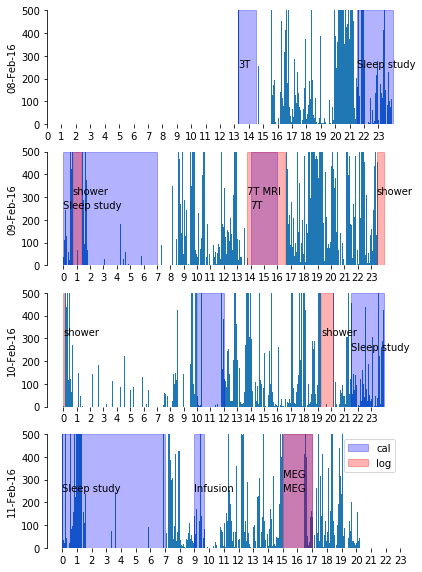

In [13]:
importlib.reload(act)

act.plot_awd(clip_dat,plots,max_act=500,show=False,fn_pref=os.path.join(out_dir,sub_long+'_M+logs'),plot_type='single',debug=True)


In [14]:
importlib.reload(act)

act.plot_awd(clip_dat,plots,max_act=250,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub_long+'_M+logs_zoom'),plot_type='single',debug=True)


NameError: name 'gc' is not defined